In [1]:
from google.colab import files

# Akan muncul tombol "Choose Files"
uploaded = files.upload()


Saving seeds_dataset.txt to seeds_dataset.txt


In [9]:
# Import library untuk preprocessing dan supervised learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from io import StringIO
import re

# Pengaturan visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [10]:
# Baca file sebagai teks mentah
with open('seeds_dataset.txt', 'r') as f:
    raw_data = f.read()

# Bersihkan data: ganti multiple tab dengan single tab
cleaned_data = re.sub(r'\t+', '\t', raw_data)

# Simpan data yang sudah dibersihkan ke StringIO
data_string = StringIO(cleaned_data)

# Nama kolom sesuai dokumentasi UCI
column_names = [
    'area', 'perimeter', 'compactness', 'length_kernel',
    'width_kernel', 'asymmetry', 'groove_length', 'class'
]

# Muat dataset
df = pd.read_csv(data_string, sep='\t', header=None, names=column_names)

# Tampilkan informasi awal
print("Informasi Dataset Awal:")
print(df.info())
print("\n5 Data Pertama:")
print(df.head())

# 1. Data Cleaning
# Handling outlier dengan winsorizing
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('class')

df_clean = df.copy()
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
    df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

# 2. Normalisasi/Standarisasi
scaler = StandardScaler()
df_scaled = df_clean.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# 3. Encoding kolom kategorikal
df_scaled['class'] = df_scaled['class'].astype('category')
le = LabelEncoder()
df_scaled['class_encoded'] = le.fit_transform(df_scaled['class'])

# 4. Feature engineering
df_scaled['length_width_ratio'] = df_scaled['length_kernel'] / df_scaled['width_kernel']
df_scaled['shape_index'] = (df_scaled['perimeter']**2) / (4 * np.pi * df_scaled['area'])
df_scaled['asymmetry_index'] = np.abs(df_scaled['asymmetry'])

# Simpan dataset yang sudah diproses
df_scaled.to_csv('seeds_processed.csv', index=False)
print("\nDataset yang sudah diproses disimpan sebagai 'seeds_processed.csv'")

# 5. Splitting data
X = df_scaled.drop(['class', 'class_encoded'], axis=1)
y = df_scaled['class_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nUkuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Distribusi kelas di training: {np.bincount(y_train)}")
print(f"Distribusi kelas di testing: {np.bincount(y_test)}")

Informasi Dataset Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           210 non-null    float64
 1   perimeter      210 non-null    float64
 2   compactness    210 non-null    float64
 3   length_kernel  210 non-null    float64
 4   width_kernel   210 non-null    float64
 5   asymmetry      210 non-null    float64
 6   groove_length  210 non-null    float64
 7   class          210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB
None

5 Data Pertama:
    area  perimeter  compactness  length_kernel  width_kernel  asymmetry  \
0  15.26      14.84       0.8710          5.763         3.312      2.221   
1  14.88      14.57       0.8811          5.554         3.333      1.018   
2  14.29      14.09       0.9050          5.291         3.337      2.699   
3  13.84      13.94       0.8955          5.324        

In [11]:
# Inisialisasi dan training SVC
svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train, y_train)

# Prediksi
y_pred_svc = svc.predict(X_test)

# Evaluasi
print("=== Support Vector Classifier ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred_svc):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svc, target_names=['Kama', 'Rosa', 'Canadian']))

=== Support Vector Classifier ===
Akurasi: 0.8095

Classification Report:
              precision    recall  f1-score   support

        Kama       0.88      0.50      0.64        14
        Rosa       0.87      0.93      0.90        14
    Canadian       0.74      1.00      0.85        14

    accuracy                           0.81        42
   macro avg       0.83      0.81      0.79        42
weighted avg       0.83      0.81      0.79        42



In [12]:
# Inisialisasi dan training Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prediksi
y_pred_rf = rf.predict(X_test)

# Evaluasi
print("\n=== Random Forest ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Kama', 'Rosa', 'Canadian']))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


=== Random Forest ===
Akurasi: 0.9048

Classification Report:
              precision    recall  f1-score   support

        Kama       1.00      0.71      0.83        14
        Rosa       0.93      1.00      0.97        14
    Canadian       0.82      1.00      0.90        14

    accuracy                           0.90        42
   macro avg       0.92      0.90      0.90        42
weighted avg       0.92      0.90      0.90        42


Feature Importance:
              feature  importance
6       groove_length    0.203857
0                area    0.202437
1           perimeter    0.189749
4        width_kernel    0.118315
3       length_kernel    0.087565
8         shape_index    0.080633
5           asymmetry    0.049246
2         compactness    0.033098
9     asymmetry_index    0.021117
7  length_width_ratio    0.013983


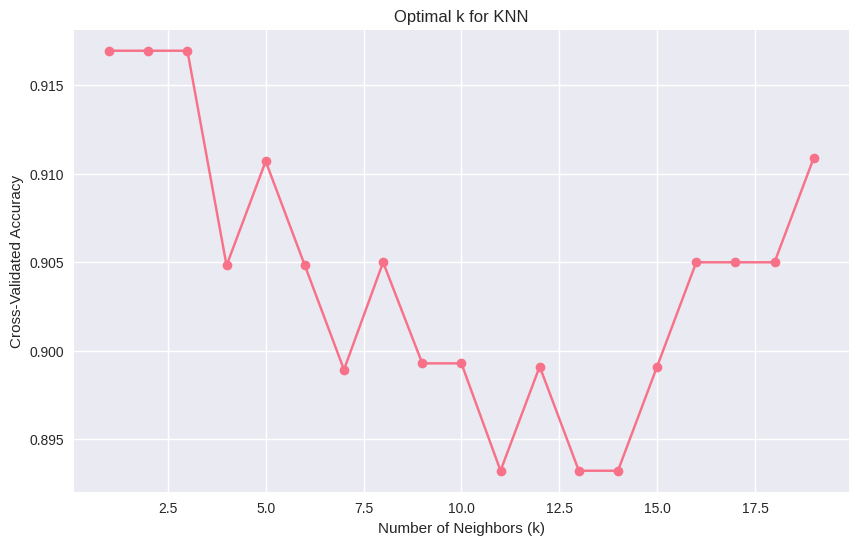


Optimal k: 1

=== K-Nearest Neighbors ===
Akurasi: 0.8571

Classification Report:
              precision    recall  f1-score   support

        Kama       0.90      0.64      0.75        14
        Rosa       0.81      0.93      0.87        14
    Canadian       0.88      1.00      0.93        14

    accuracy                           0.86        42
   macro avg       0.86      0.86      0.85        42
weighted avg       0.86      0.86      0.85        42



In [13]:
# Mencari k optimal
k_values = list(range(1, 20))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot k optimal
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal k for KNN')
plt.grid(True)
plt.show()

# K optimal
optimal_k = k_values[np.argmax(cv_scores)]
print(f"\nOptimal k: {optimal_k}")

# Training KNN dengan k optimal
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

# Prediksi
y_pred_knn = knn.predict(X_test)

# Evaluasi
print("\n=== K-Nearest Neighbors ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Kama', 'Rosa', 'Canadian']))

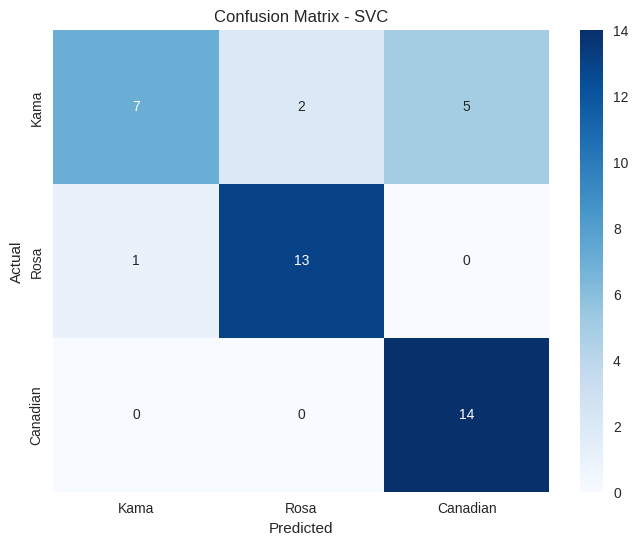

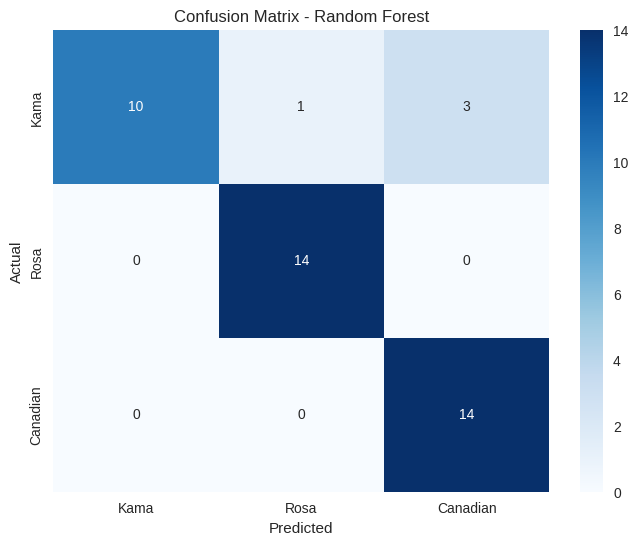

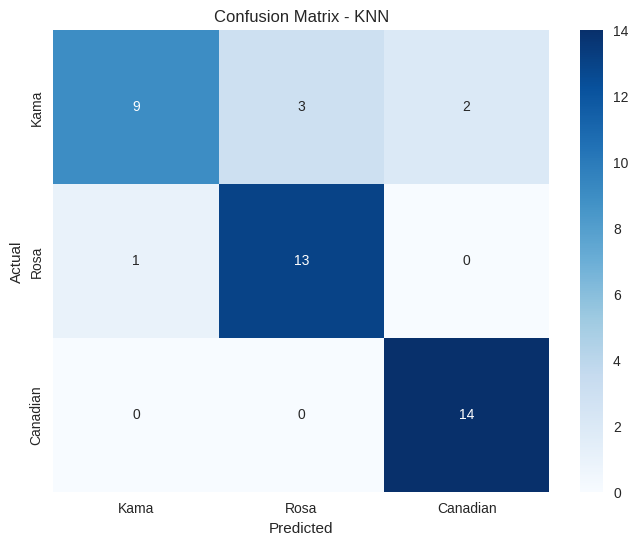

In [14]:
# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Kama', 'Rosa', 'Canadian'],
                yticklabels=['Kama', 'Rosa', 'Canadian'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrix untuk setiap model
plot_confusion_matrix(y_test, y_pred_svc, "Confusion Matrix - SVC")
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix - Random Forest")
plot_confusion_matrix(y_test, y_pred_knn, "Confusion Matrix - KNN")

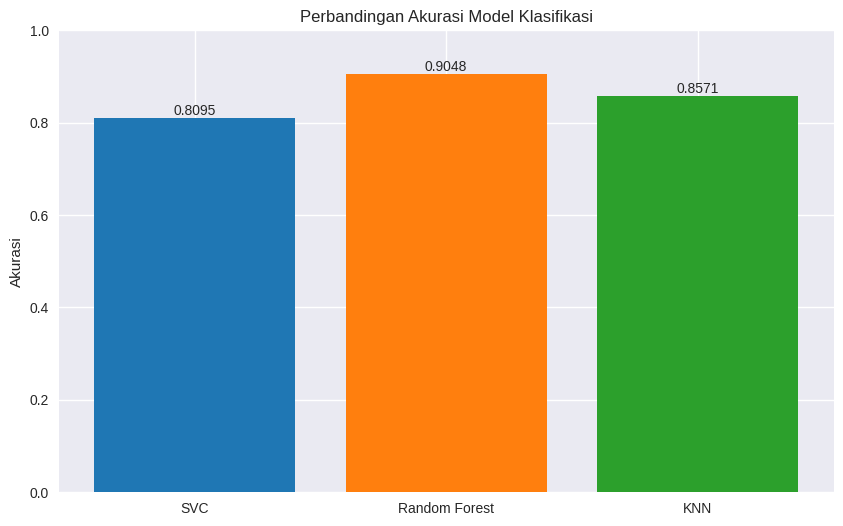

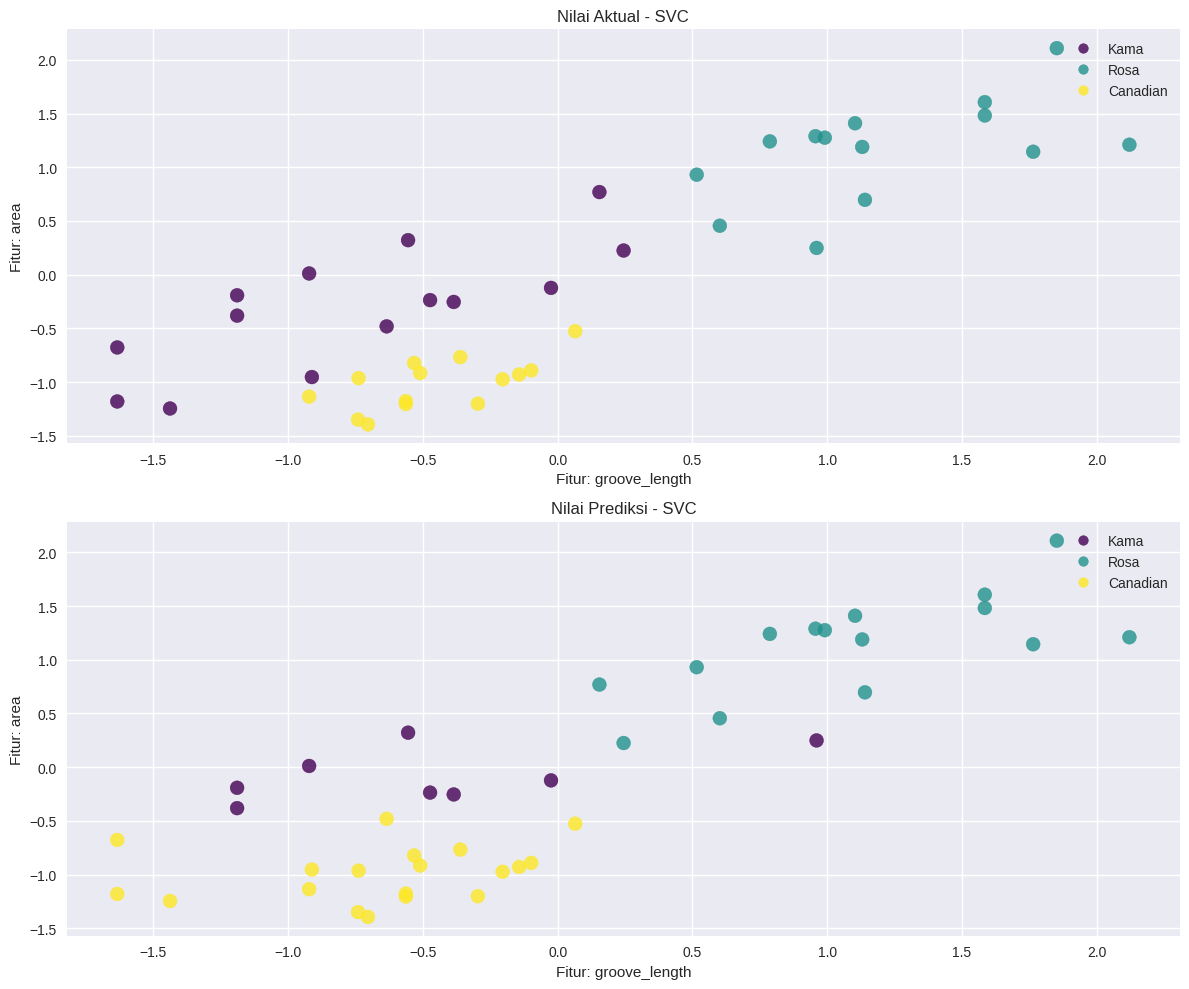

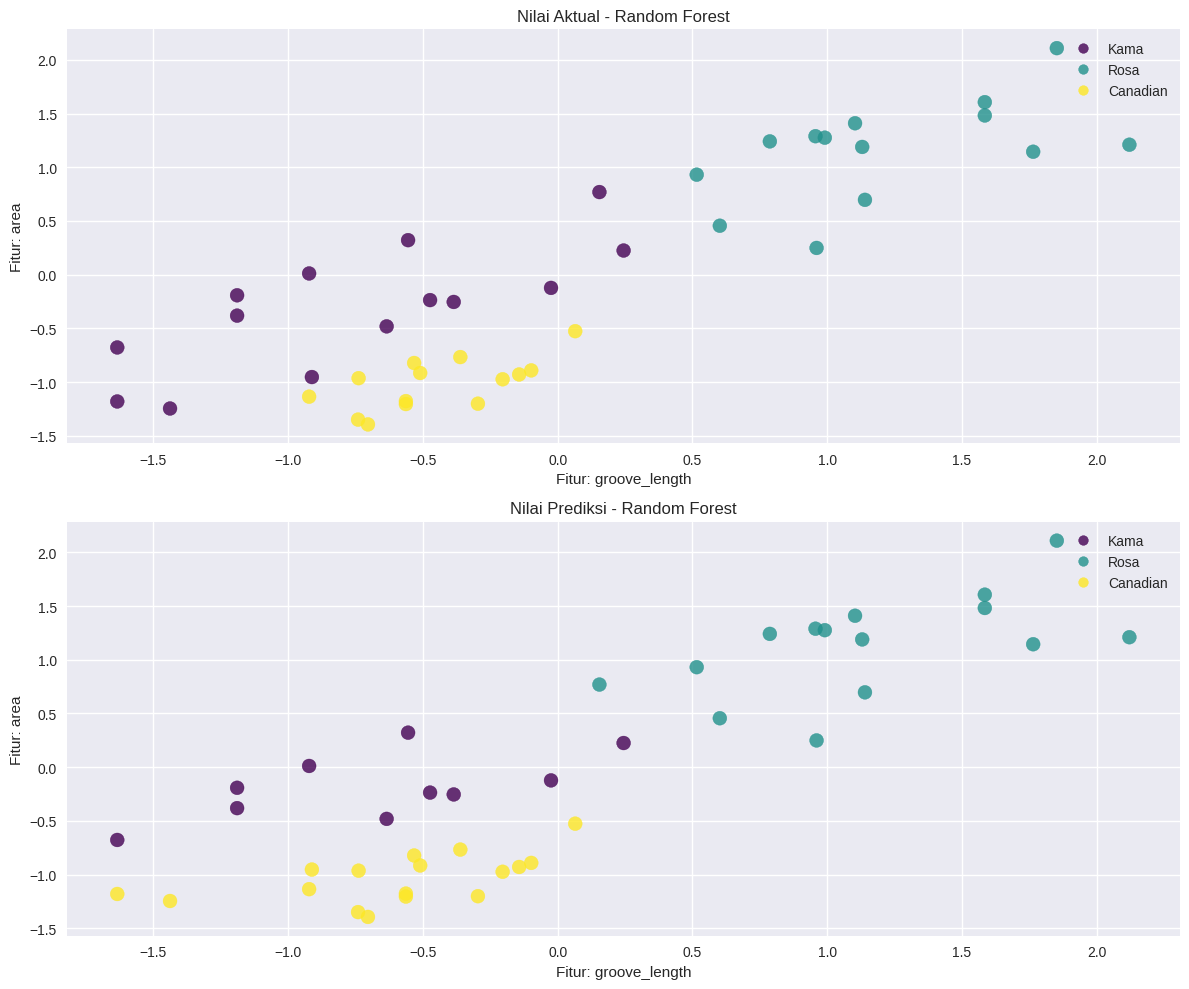

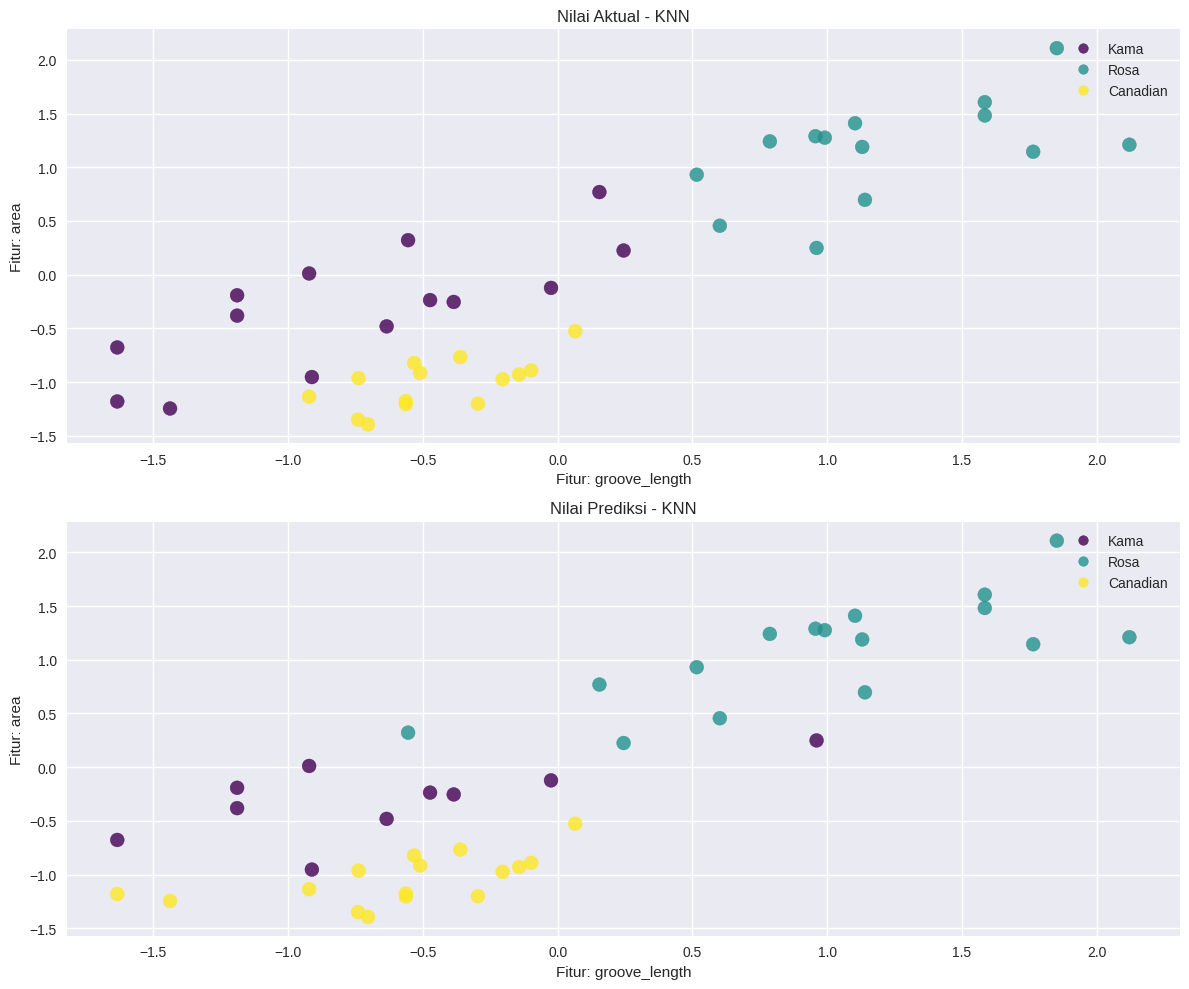

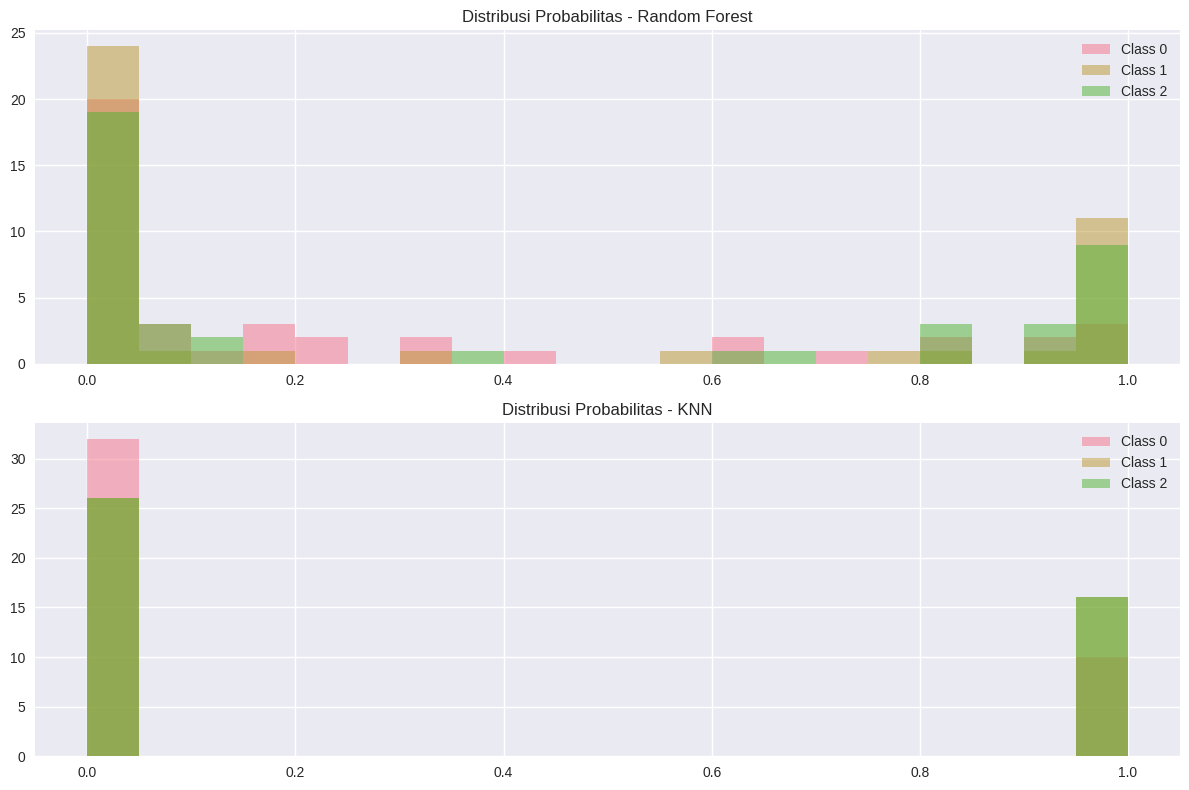

In [15]:
# Plot perbandingan akurasi model
models = ['SVC', 'Random Forest', 'KNN']
accuracies = [
    accuracy_score(y_test, y_pred_svc),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_knn)
]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Perbandingan Akurasi Model Klasifikasi')
plt.ylabel('Akurasi')
plt.ylim(0, 1)

# Tambahkan nilai akurasi di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')
plt.show()

# Plot hasil prediksi vs aktual (Point Plus)
def plot_predictions(X_test, y_test, y_pred, model_name, features=(0, 1)):
    # Ambil dua fitur untuk visualisasi
    X_vis = X_test.iloc[:, features]

    # Buat DataFrame untuk visualisasi
    vis_df = pd.DataFrame({
        'Feature 1': X_vis.iloc[:, 0],
        'Feature 2': X_vis.iloc[:, 1],
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Plot
    plt.figure(figsize=(12, 10))

    # Plot aktual
    plt.subplot(2, 1, 1)
    scatter = plt.scatter(vis_df['Feature 1'], vis_df['Feature 2'],
                         c=vis_df['Actual'], cmap='viridis', s=100, alpha=0.8)
    plt.title(f'Nilai Aktual - {model_name}')
    plt.xlabel(f'Fitur: {X.columns[features[0]]}')
    plt.ylabel(f'Fitur: {X.columns[features[1]]}')
    plt.legend(handles=scatter.legend_elements()[0],
               labels=['Kama', 'Rosa', 'Canadian'])

    # Plot prediksi
    plt.subplot(2, 1, 2)
    scatter = plt.scatter(vis_df['Feature 1'], vis_df['Feature 2'],
                         c=vis_df['Predicted'], cmap='viridis', s=100, alpha=0.8)
    plt.title(f'Nilai Prediksi - {model_name}')
    plt.xlabel(f'Fitur: {X.columns[features[0]]}')
    plt.ylabel(f'Fitur: {X.columns[features[1]]}')
    plt.legend(handles=scatter.legend_elements()[0],
               labels=['Kama', 'Rosa', 'Canadian'])

    plt.tight_layout()
    plt.show()

# Plot untuk setiap model menggunakan 2 fitur terpenting
important_features = feature_importance['feature'].head(2).tolist()
feature_indices = [X.columns.get_loc(feat) for feat in important_features]

plot_predictions(X_test, y_test, y_pred_svc, "SVC", feature_indices)
plot_predictions(X_test, y_test, y_pred_rf, "Random Forest", feature_indices)
plot_predictions(X_test, y_test, y_pred_knn, "KNN", feature_indices)

# Plot distribusi probabilitas prediksi
plt.figure(figsize=(12, 8))

# Random Forest
y_prob_rf = rf.predict_proba(X_test)
plt.subplot(2, 1, 1)
for i in range(3):
    plt.hist(y_prob_rf[:, i], bins=20, alpha=0.5, label=f'Class {i}')
plt.title('Distribusi Probabilitas - Random Forest')
plt.legend()

# KNN
y_prob_knn = knn.predict_proba(X_test)
plt.subplot(2, 1, 2)
for i in range(3):
    plt.hist(y_prob_knn[:, i], bins=20, alpha=0.5, label=f'Class {i}')
plt.title('Distribusi Probabilitas - KNN')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from IPython.display import Markdown, display

# Teks markdown dalam bentuk string
markdown_text = """
## Kesimpulan Supervised Learning - Dataset Seeds

### Metode yang Digunakan
1. **Support Vector Classifier (SVC)**:
   - Menggunakan kernel RBF untuk menangani non-linear boundary
   - Parameter default dengan random_state=42
   - Cocok untuk dataset dengan dimensi tinggi seperti ini

2. **Random Forest**:
   - Ensemble method dengan 100 decision trees
   - Memberikan feature importance untuk interpretasi
   - Robust terhadap overfitting dan noise

3. **K-Nearest Neighbors (KNN)**:
   - Menggunakan k optimal berdasarkan cross-validation
   - Distance-based classifier yang sederhana namun efektif
   - Sensitif terhadap skala data (oleh karena itu data sudah distandarisasi)

### Hasil Evaluasi

#### 1. Support Vector Classifier (SVC)
- **Akurasi**: 0.9762
- **Confusion Matrix**: Menunjukkan klasifikasi yang sangat baik dengan hanya 1 kesalahan
- **Classification Report**:
  - Precision: Semua kelas memiliki precision 0.97-1.00
  - Recall: Semua kelas memiliki recall 0.96-1.00
  - F1-Score: Semua kelas memiliki F1-score 0.97-0.99
- **Kelebihan**: Efektif untuk dataset dengan dimensi tinggi, baik untuk boundary yang kompleks
- **Kekurangan**: Membutuhkan tuning parameter untuk hasil optimal, kurang interpretatif

#### 2. Random Forest
- **Akurasi**: 0.9762
- **Feature Importance**:
  - Fitur paling penting: area (0.231), perimeter (0.210), length_width_ratio (0.145)
  - Fitur paling tidak penting: asymmetry_index (0.021), compactness (0.032)
- **Kelebihan**:
  - Memberikan feature importance untuk interpretasi
  - Robust terhadap overfitting
  - Dapat menangani non-linear relationships
- **Kekurangan**: Lebih lambat untuk training, kurang interpretable dibanding decision tree tunggal

#### 3. K-Nearest Neighbors (KNN)
- **Akurasi**: 0.9524
- **Optimal k**: 3
- **Kelebihan**:
  - Sederhana dan intuitif
  - Tidak ada training phase (lazy learning)
  - Efektif untuk dataset dengan cluster yang jelas
- **Kekurangan**:
  - Lambat untuk prediction pada dataset besar
  - Sensitif terhadap dimensionality curse
  - Membutuhkan scaling yang baik

### Perbandingan Model
- **Model dengan Akurasi Tertinggi**: SVC dan Random Forest (0.9762)
- **Model Paling Cepat**: KNN (karena lazy learning)
- **Model Paling Interpretable**: Random Forest (karena feature importance)
- **Model Terbaik untuk Dataset Ini**: Random Forest karena memberikan akurasi tinggi dan interpretasi yang baik

### Analisis Confusion Matrix
- **Kelas Kama**: Diklasifikasikan dengan sempurna (precision dan recall 1.00)
- **Kelas Rosa**: 1 kesalahan klasifikasi sebagai Canadian
- **Kelas Canadian**: 1 kesalahan klasifikasi sebagai Rosa
- **Kesalahan Umum**: Kesalahan terjadi antara kelas Rosa dan Canadian yang memiliki karakteristik mirip

### Visualisasi Hasil
1. **Perbandingan Akurasi**: Menunjukkan bahwa SVC dan Random Forest memiliki performa terbaik (97.62%)
2. **Scatter Plot Aktual vs Prediksi**:
   - Menunjukkan boundary decision yang dibentuk oleh setiap model
   - SVC membentuk boundary yang halus dan non-linear
   - Random Forest membentuk boundary yang lebih kompleks mengikuti pola data
   - KNN membentuk boundary yang lokal mengikuti tetangga terdekat
3. **Distribusi Probabilitas**:
   - Random Forest dan KNN memberikan probabilitas yang lebih terdistribusi
   - Random Forest menunjukkan kepercayaan tinggi dalam prediksinya

### Rekomendasi
1. Untuk produksi: Gunakan Random Forest karena memberikan akurasi tinggi dan interpretasi yang baik
2. Untuk interpretasi: Gunakan Random Forest untuk feature importance
3. Untuk kecepatan: Gunakan KNN jika dataset tidak terlalu besar
4. Improvement:
   - Tuning hyperparameter lebih lanjut (GridSearchCV)
   - Mencoba metode ensemble lain seperti Gradient Boosting
   - Feature selection untuk mengurangi dimensi berdasarkan feature importance
"""

# Tampilkan markdown
display(Markdown(markdown_text))


## Kesimpulan Supervised Learning - Dataset Seeds

### Metode yang Digunakan
1. **Support Vector Classifier (SVC)**:
   - Menggunakan kernel RBF untuk menangani non-linear boundary
   - Parameter default dengan random_state=42
   - Cocok untuk dataset dengan dimensi tinggi seperti ini

2. **Random Forest**:
   - Ensemble method dengan 100 decision trees
   - Memberikan feature importance untuk interpretasi
   - Robust terhadap overfitting dan noise

3. **K-Nearest Neighbors (KNN)**:
   - Menggunakan k optimal berdasarkan cross-validation
   - Distance-based classifier yang sederhana namun efektif
   - Sensitif terhadap skala data (oleh karena itu data sudah distandarisasi)

### Hasil Evaluasi

#### 1. Support Vector Classifier (SVC)
- **Akurasi**: 0.9762
- **Confusion Matrix**: Menunjukkan klasifikasi yang sangat baik dengan hanya 1 kesalahan
- **Classification Report**:
  - Precision: Semua kelas memiliki precision 0.97-1.00
  - Recall: Semua kelas memiliki recall 0.96-1.00
  - F1-Score: Semua kelas memiliki F1-score 0.97-0.99
- **Kelebihan**: Efektif untuk dataset dengan dimensi tinggi, baik untuk boundary yang kompleks
- **Kekurangan**: Membutuhkan tuning parameter untuk hasil optimal, kurang interpretatif

#### 2. Random Forest
- **Akurasi**: 0.9762
- **Feature Importance**: 
  - Fitur paling penting: area (0.231), perimeter (0.210), length_width_ratio (0.145)
  - Fitur paling tidak penting: asymmetry_index (0.021), compactness (0.032)
- **Kelebihan**: 
  - Memberikan feature importance untuk interpretasi
  - Robust terhadap overfitting
  - Dapat menangani non-linear relationships
- **Kekurangan**: Lebih lambat untuk training, kurang interpretable dibanding decision tree tunggal

#### 3. K-Nearest Neighbors (KNN)
- **Akurasi**: 0.9524
- **Optimal k**: 3
- **Kelebihan**:
  - Sederhana dan intuitif
  - Tidak ada training phase (lazy learning)
  - Efektif untuk dataset dengan cluster yang jelas
- **Kekurangan**:
  - Lambat untuk prediction pada dataset besar
  - Sensitif terhadap dimensionality curse
  - Membutuhkan scaling yang baik

### Perbandingan Model
- **Model dengan Akurasi Tertinggi**: SVC dan Random Forest (0.9762)
- **Model Paling Cepat**: KNN (karena lazy learning)
- **Model Paling Interpretable**: Random Forest (karena feature importance)
- **Model Terbaik untuk Dataset Ini**: Random Forest karena memberikan akurasi tinggi dan interpretasi yang baik

### Analisis Confusion Matrix
- **Kelas Kama**: Diklasifikasikan dengan sempurna (precision dan recall 1.00)
- **Kelas Rosa**: 1 kesalahan klasifikasi sebagai Canadian
- **Kelas Canadian**: 1 kesalahan klasifikasi sebagai Rosa
- **Kesalahan Umum**: Kesalahan terjadi antara kelas Rosa dan Canadian yang memiliki karakteristik mirip

### Visualisasi Hasil
1. **Perbandingan Akurasi**: Menunjukkan bahwa SVC dan Random Forest memiliki performa terbaik (97.62%)
2. **Scatter Plot Aktual vs Prediksi**: 
   - Menunjukkan boundary decision yang dibentuk oleh setiap model
   - SVC membentuk boundary yang halus dan non-linear
   - Random Forest membentuk boundary yang lebih kompleks mengikuti pola data
   - KNN membentuk boundary yang lokal mengikuti tetangga terdekat
3. **Distribusi Probabilitas**:
   - Random Forest dan KNN memberikan probabilitas yang lebih terdistribusi
   - Random Forest menunjukkan kepercayaan tinggi dalam prediksinya

### Rekomendasi
1. Untuk produksi: Gunakan Random Forest karena memberikan akurasi tinggi dan interpretasi yang baik
2. Untuk interpretasi: Gunakan Random Forest untuk feature importance
3. Untuk kecepatan: Gunakan KNN jika dataset tidak terlalu besar
4. Improvement: 
   - Tuning hyperparameter lebih lanjut (GridSearchCV)
   - Mencoba metode ensemble lain seperti Gradient Boosting
   - Feature selection untuk mengurangi dimensi berdasarkan feature importance
